In [3]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

In [4]:
gi100 = np.load('gittins_100.npy')
gi200 = np.load('gittins_200.npy')
gi1000 = np.load('gittins_1000.npy')

In [5]:
def SE(x1, x2, v, l): # Squared exponential covariance function
    return v ** 2 * np.exp(- 0.5 * (x1[:, None] - x2[None, :]) ** 2 / l ** 2)

In [8]:
class MAB:
    def __init__(self, n_bandits, methods=[]):
        self.n_bandits = n_bandits
        self.methods = methods
    
    def set_mu(self, vl):
        if vl is None:
            self.mu = np.random.normal(size=self.n_bandits)
        else:
            cov = SE(np.arange(self.n_bandits), np.arange(self.n_bandits), *vl)
            self.mu = np.random.multivariate_normal(np.zeros(self.n_bandits), cov)
        
    def episode(self, n_steps, vl, gi, gamma, eps, c):
           
        actions = {key:np.zeros(n_steps, dtype=np.int32) for key in self.methods}
        optimal = {key:np.zeros(n_steps, dtype=np.int32) for key in self.methods}
        rewards = {key:np.zeros(n_steps) for key in self.methods}
        disc_rewards = {key:np.zeros(n_steps) for key in self.methods}
        
        nb = self.n_bandits
        
        for method in self.methods: # All methods get tested on same sets of mus for fairness
            n = np.zeros(nb, dtype=np.int32) # Number of times each action is taken
            q = np.zeros(nb) # Estimated mean for each action

            for step in range(n_steps): # Determine appropriate action at each step

                if method.startswith('cor gittins'):
                    acts = actions['cor gittins'][:step]
                    rews = rewards['cor gittins'][:step]
                    ktest = SE(np.arange(nb), acts, *vl)
                    Kinv = np.linalg.inv(SE(acts, acts, *vl) + np.identity(step))
                    gq = ktest @ Kinv @ rews # Posterior mean
                    cov = SE(np.arange(nb), np.arange(nb), *vl) - ktest @ Kinv @ ktest.T # Posterior covariance
                    nhat = 1 / np.diag(cov) # Effective n
                    nhat = np.minimum(nhat, gi.shape[0]) # Clip to acceptable numbers for our range of GI
                    nhat_int = nhat.astype(np.int32)
                    
                    gi0 = np.append(gi, [0,0]) # If nhat is too large for our range of GI, let it be 0
                    
                    g1 = gi0[nhat_int]
                    g2 = gi0[nhat_int + 1]
                    index = gq + g1 + (nhat - nhat_int) * (g2 - g1) # Interpolate exploration boni
                    
                    action = index.argmax()
                                
                elif method.startswith('gittins'):
                    gi0 = np.append(gi, 0)
                    index = q + gi0[np.minimum(n+1, gi.shape[0])]
                    action = index.argmax()
                    
                elif method.startswith('thompson'):
                    samples = np.random.normal(q, np.sqrt(1 / (n + 1)))
                    action = samples.argmax()
                          
                elif method.startswith('ucb'):
                    if step == 0: 
                        # Step through provided c's
                        if isinstance(c, float) or isinstance(c, int):
                            cc = c
                        else:
                            cc = c[0]
                            c = c[1:]
                    
                    if n.min() == 0:
                        action = n.argmin()
                    else:
                        index = q + cc * np.sqrt(np.log(step + 1) / n)
                        action = index.argmax()
        
                elif method.startswith('eps greedy'):
                    if step == 0: # Step through provided eps's
                        if isinstance(eps, float) or isinstance(eps, int):
                            e = eps
                        else:
                            e = eps[0]
                            eps = eps[1:]                        
                    if e > np.random.random():
                        action = np.random.randint(nb)
                    else:
                        action = q.argmax()
                        
                elif method == 'random':
                    action = np.random.randint(nb)
                        
                rew = np.random.normal(self.mu[action]) # Generate reward
                #print('rew', rew)
                n[action] += 1
                q[action] += (rew - q[action]) / n[action]
                
                actions[method][step] = action                     
                optimal[method][step] = action == np.argmax(self.mu)
                rewards[method][step] = rew
                disc_rewards[method][step] = rew * gamma ** step
            
        return actions, optimal, rewards, disc_rewards
    
    def run(self, n_eps, n_steps,  vl=None, gi=None, gamma=None, eps=None, c=None):
        self.actions = {key:np.zeros((n_eps, n_steps)) for key in self.methods}
        self.optimal = {key:np.zeros((n_eps, n_steps)) for key in self.methods}
        self.rewards = {key:np.zeros((n_eps, n_steps)) for key in self.methods}
        self.disc_rewards = {key:np.zeros((n_eps, n_steps)) for key in self.methods}
        self.mus = np.zeros((n_eps, self.n_bandits))
        
        for ep in tqdm(range(n_eps)):
            self.set_mu(vl)
            self.mus[ep, :] = self.mu
            a, o, r, d = self.episode(n_steps, vl, gi, gamma, eps, c)
            for method in self.methods:
                self.actions[method][ep, :] = a[method]
                self.optimal[method][ep, :] = o[method]
                self.rewards[method][ep, :] = r[method]
                self.disc_rewards[method][ep, :] = d[method]        

In [240]:
mab = MAB(50, methods=['cor gittins', 'gittins', 'ucb 0.2','ucb 0.5', 'thompson', 'eps greedy 0.1'])
mab.run(500, 300, vl=[1,4], gi=gi100, gamma=0.99,eps=0.1, c=[0.2, 0.5])

In [241]:
for method in mab.rewards:
    print(method, ': ', mab.disc_rewards[method].sum(axis=1).mean().round(3))

cor gittins :  117.392
gittins :  73.774
ucb 0.2 :  74.227
ucb 0.5 :  70.206
thompson :  72.473
eps greedy 0.1 :  79.444


In [242]:
bests = np.zeros(len(mab.rewards.keys()))
n = mab.rewards['cor gittins'].shape[1]
for i in range(n):
    best = np.array([mab.rewards[m][i,:].max() for m in mab.rewards.keys()]).argmax()
    bests[best] += 1
    
print([(m, b/n) for m, b in zip(mab.rewards.keys(), bests)])

[('cor gittins', 0.16333333333333333), ('gittins', 0.09333333333333334), ('ucb 0.2', 0.18333333333333332), ('ucb 0.5', 0.23333333333333334), ('thompson', 0.17333333333333334), ('eps greedy 0.1', 0.15333333333333332)]


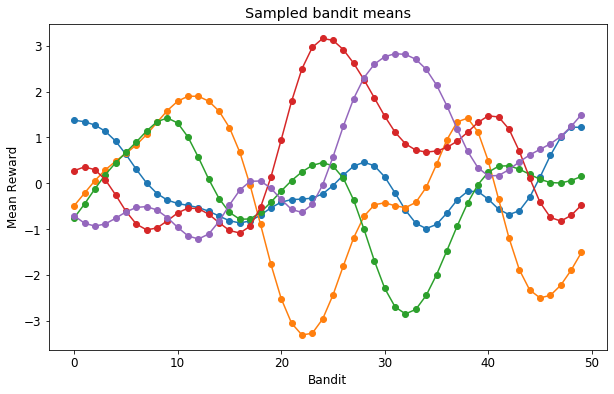

In [243]:
plt.figure(figsize=(10,6))
for i in range(5):
    plt.plot(mab.mus[i,:],marker='o')
plt.xlabel('Bandit')
plt.ylabel('Mean Reward')
plt.title('Sampled bandit means')
plt.show()

In [244]:
mdr = [] # mean instantanious discounted rewards
cdr = [] # cumulative discounted rewards
adr = [] # average discounted rewards
for key in mab.disc_rewards:
    mdr.append(mab.disc_rewards[key].mean(axis=0))
    cdr.append(np.cumsum(mab.disc_rewards[key], axis=1).mean(axis=0))
    adr.append((np.cumsum(mab.disc_rewards[key], axis=1) / np.arange(1, mab.disc_rewards[key].shape[1] + 1)).mean(axis=0))

In [245]:
plt.rcParams.update({'font.size':12})

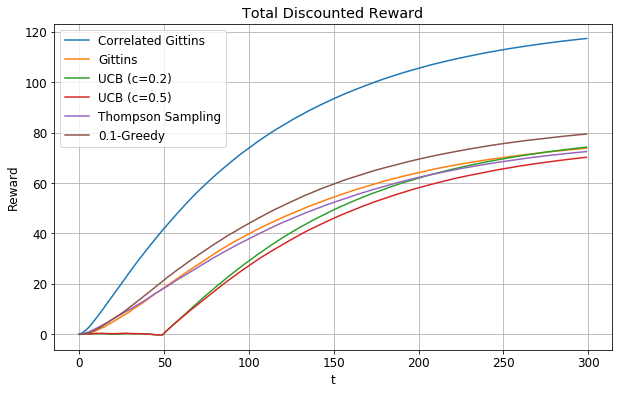

In [246]:
plt.figure(figsize=(10,6))
plt.title('Total Discounted Reward')
for d in cdr:
    plt.plot(d)
plt.xlabel('t')
plt.ylabel('Reward')
plt.legend(mab.disc_rewards.keys())
plt.legend(['Correlated Gittins', 'Gittins', 'UCB (c=0.2)', 'UCB (c=0.5)', 'Thompson Sampling', '0.1-Greedy'])
plt.grid()
plt.show()